In [ ]:
from google.colab import drive
drive.mount('gdrive')
!unzip gdrive/My\ Drive/ColabNotebooks/zip

Mounted at gdrive
Archive:  gdrive/My Drive/ColabNotebooks/zip
   creating: content/
   creating: content/.config/
 extracting: content/.config/active_config  
   creating: content/.config/configurations/
  inflating: content/.config/configurations/config_default  
   creating: content/.config/logs/
   creating: content/.config/logs/2021.08.25/
  inflating: content/.config/logs/2021.08.25/13.35.16.953377.log  
  inflating: content/.config/logs/2021.08.25/13.35.22.941499.log  
  inflating: content/.config/logs/2021.08.25/13.34.42.215914.log  
  inflating: content/.config/logs/2021.08.25/13.35.41.801770.log  
  inflating: content/.config/logs/2021.08.25/13.35.00.944587.log  
  inflating: content/.config/logs/2021.08.25/13.35.40.963605.log  
 extracting: content/.config/config_sentinel  
 extracting: content/.config/gce     
  inflating: content/.config/.last_update_check.json  
 extracting: content/.config/.last_opt_in_prompt.yaml  
 extracting: content/.config/.last_survey_prompt.yaml  

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1661033 sha256=76d14277dfbd9e059cf4ac6d9aaa520f71635f6d752f7b316437b4932072a72a
  Stored in directory: /tmp/pip-ephem-wheel-cache-4mda7tsa/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=ebff1e783eeea665766d42f364a35460de8557f8c3dab640cb9a5b1d08d9e3c6
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for avro-python3: filename=avro_python3-1.9.2.1-py3-none-any.whl size=43512 sha256=8dffecdab4b6836c4eb03582eef876a7aaf8545cf6ebd55847d825bddca2da00
  Stored in directory: /root/.cache/pip/wheels/bc/49/5f/fdb5b9d85055c478213e0158ac122b596816149a02d82e0ab1
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78546 sha256=21d8400582725c742da3a04dd6d9b69b8c165d14c9234deff

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
# NOTE: Update these TFRecord names from "cells" and "cells_label_map" to your files!
test_record_fname = '/content/valid/spiky.tfrecord'
train_record_fname = '/content/train/spiky.tfrecord'
label_map_pbtxt_fname = '/content/train/spiky_label_map.pbtxt'

In [ ]:
##change chosen model to deploy different models available in the TF2 object detection zoo
MODELS_CONFIG = {
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
    'efficientdet-d1': {
        'model_name': 'efficientdet_d1_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d1_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d1_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
    'efficientdet-d2': {
        'model_name': 'efficientdet_d2_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d2_768x768_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d2_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
        'efficientdet-d3': {
        'model_name': 'efficientdet_d3_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d3_896x896_coco17_tpu-32.config',
        'pretrained_checkpoint': 'efficientdet_d3_coco17_tpu-32.tar.gz',
        'batch_size': 16
    }
}

#in this tutorial we implement the lightweight, smallest state of the art efficientdet model
#if you want to scale up tot larger efficientdet models you will likely need more compute!
chosen_model = 'efficientdet-d0'

num_steps = 40000 #The more steps, the longer the training. Increase if your loss function is still decreasing and validation metrics are increasing. 
num_eval_steps = 500 #Perform evaluation after so many steps

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']
batch_size = MODELS_CONFIG[chosen_model]['batch_size'] #if you can fit a large batch in memory, it may speed up your training

In [ ]:
pipeline_file = '/content/models/research/deploy/pipeline_file.config'
model_dir = '/content/training/'

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
%ls '/content/training/'

checkpoint                   ckpt-38.index
ckpt-35.data-00000-of-00001  ckpt-39.data-00000-of-00001
ckpt-35.index                ckpt-39.index
ckpt-36.data-00000-of-00001  ckpt-40.data-00000-of-00001
ckpt-36.index                ckpt-40.index
ckpt-37.data-00000-of-00001  ckpt-41.data-00000-of-00001
ckpt-37.index                ckpt-41.index
ckpt-38.data-00000-of-00001  train/


In [ ]:
import pathlib

filenames = list(pathlib.Path('/content/training/').glob('*.index'))

filenames.sort()
print(filenames)

#recover our saved model
pipeline_config = pipeline_file
#generally you want to put the last ckpt from training in here
model_dir = str(filenames[-1]).replace('.index','')
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(str(filenames[-1]).replace('.index','')))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

[PosixPath('/content/training/ckpt-35.index'), PosixPath('/content/training/ckpt-36.index'), PosixPath('/content/training/ckpt-37.index'), PosixPath('/content/training/ckpt-38.index'), PosixPath('/content/training/ckpt-39.index'), PosixPath('/content/training/ckpt-40.index'), PosixPath('/content/training/ckpt-41.index')]


In [ ]:
#map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  x = np.array(image.getdata())
  if np.size(np.array(image.getdata())[0]) == 3:
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
    # print("here")
  elif np.size(np.array(image.getdata())[0]) == 1:
    bigarr = []
    for i in np.arange(len(np.array(image.getdata()))):
      temp = [x[i], x[i], x[i]]
      bigarr += [temp]
    # print(np.shape(np.array(bigarr)))
    return np.array(bigarr).reshape((im_height, im_width, 3)).astype(np.uint8)


/content/test/210825.125518/[08262021_200420_570]Filter[RBC]_Image[37].jpg
objs 0


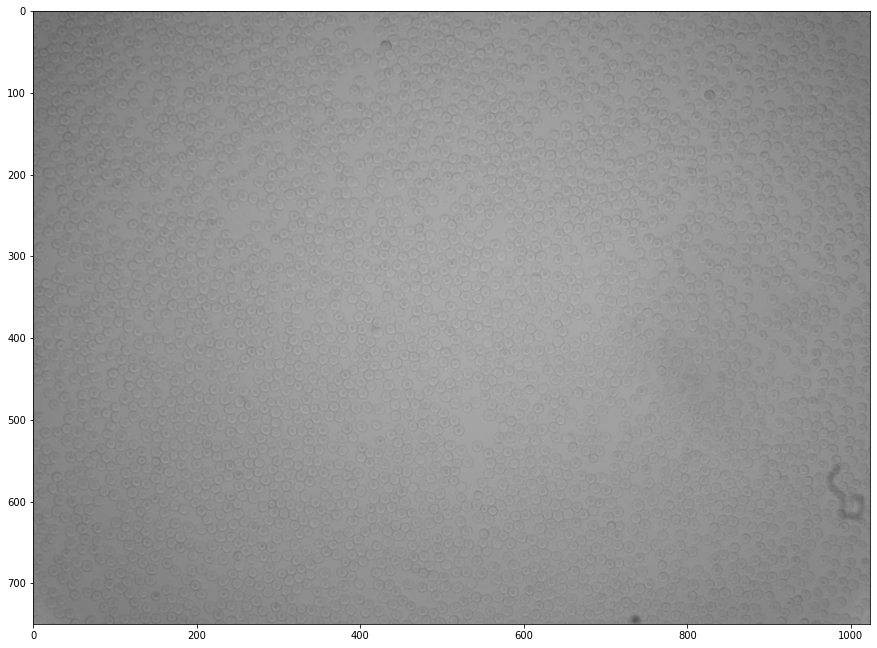

/content/test/210825.125518/[08262021_201417_379]Filter[RBC]_Image[83].jpg
objs 1


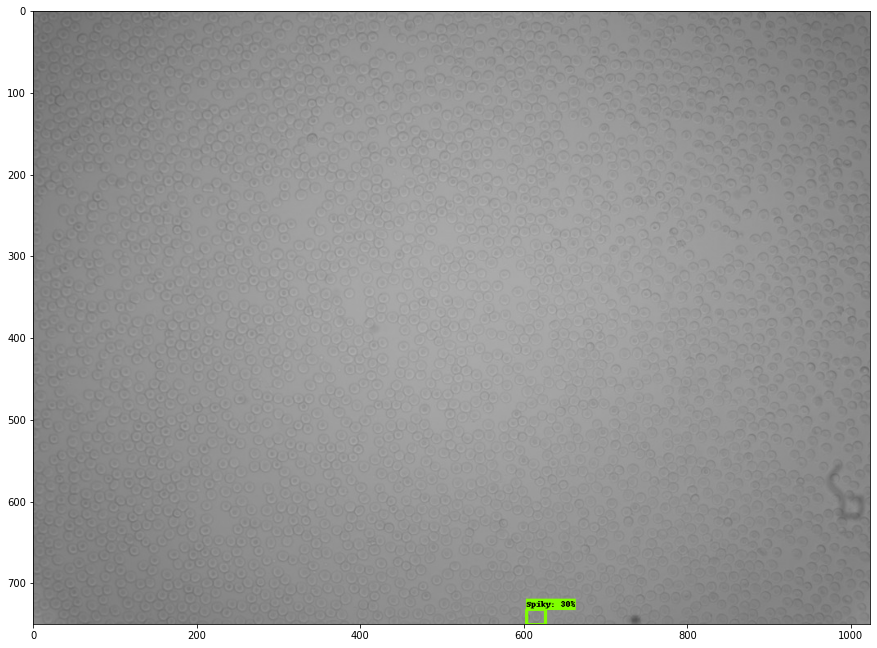

/content/test/210825.125518/[08262021_201309_177]Filter[RBC]_Image[78].jpg
objs 0


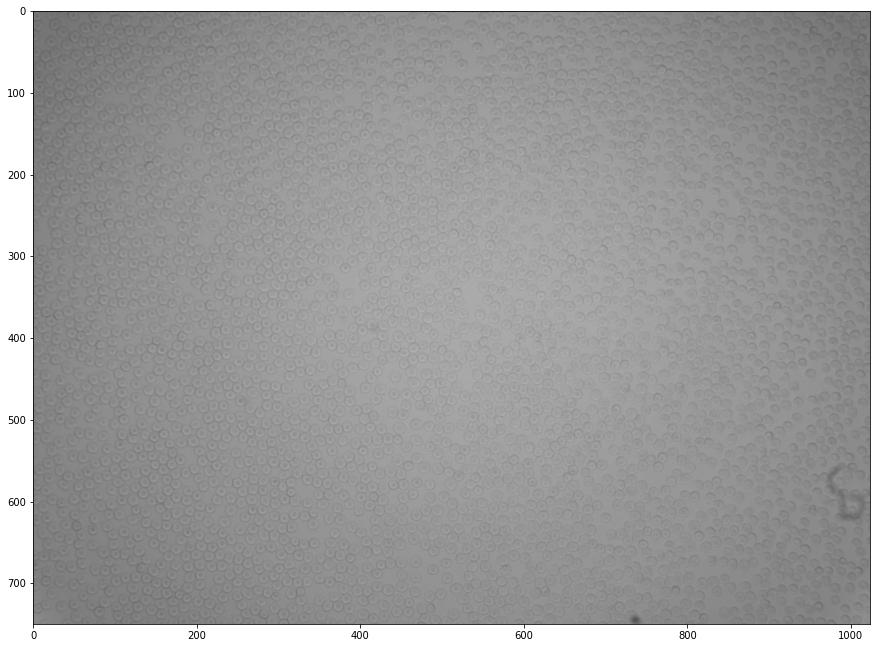

/content/test/210825.125518/[08262021_200357_220]Filter[RBC]_Image[35].jpg
objs 0
/content/test/210825.125518/[08262021_195855_092]Filter[RBC]_Image[10].jpg
objs 2
/content/test/210825.125518/[08262021_202006_457]Filter[RBC]_Image[112].jpg
objs 0
/content/test/210825.125518/[08262021_201810_209]Filter[RBC]_Image[102].jpg
objs 0
/content/test/210825.125518/[08262021_201713_411]Filter[RBC]_Image[98].jpg
objs 0
/content/test/210825.125518/[08262021_201233_890]Filter[RBC]_Image[75].jpg
objs 0
/content/test/210825.125518/[08262021_201158_456]Filter[RBC]_Image[72].jpg
objs 0
/content/test/210825.125518/[08262021_200028_206]Filter[RBC]_Image[18].jpg
objs 1
/content/test/210825.125518/[08262021_195808_278]Filter[RBC]_Image[6].jpg
objs 0
/content/test/210825.125518/[08262021_202116_567]Filter[RBC]_Image[118].jpg
objs 0
/content/test/210825.125518/[08262021_201602_575]Filter[RBC]_Image[92].jpg
objs 0
/content/test/210825.125518/[08262021_200016_533]Filter[RBC]_Image[17].jpg
objs 0
/content/test/

In [ ]:
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 
import random
from openpyxl import load_workbook
from openpyxl import Workbook

try:
    wb = load_workbook(filename= 'tempdata.xlsx')
except FileNotFoundError:
    wb = Workbook()
ws = wb.active

row = 1

count = 0
TEST_IMAGE_PATHS = glob.glob('/content/test/210825.125518/*.jpg')
for image in TEST_IMAGE_PATHS:
  
  image_path = image
  print(image_path)

  image_np = load_image_into_numpy_array(image_path)

  # Things to try:
  # Flip horizontally
  # image_np = np.fliplr(image_np).copy()

  # Convert image to grayscale
  # image_np = np.tile(
  #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

  input_tensor = tf.convert_to_tensor(
      np.expand_dims(image_np, 0), dtype=tf.float32)
  detections, predictions_dict, shapes = detect_fn(input_tensor)
  # print("detections", detections['num_detections'][0].numpy())


  label_id_offset = 1
  image_np_with_detections = image_np.copy()

  min_score_threshold = 0.25
  scores =  detections['detection_scores'][0].numpy()
  objects_detected = 0
  for i in scores:
    if i >= min_score_threshold:
      objects_detected +=1
  print("objs", objects_detected)
  ws.cell(row, 1, objects_detected)
  ws.cell(row,2, image_path.partition('].jpg')[0].partition('Image[')[2])
  row +=1


  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=4000,
        min_score_thresh=min_score_threshold,
        agnostic_mode=False,
  )

  if count < 3:
    plt.figure(figsize=(15,15))
    plt.imshow(image_np_with_detections)
    plt.show()
  elif objects_detected >= 14:
    plt.figure(figsize=(15,15))
    plt.imshow(image_np_with_detections)
    plt.show()
  count +=1

while True:
      try:
          wb.save('tempdata.xlsx')
          print("saved")
          break
      except Exception as e:
          print(e)